<a href="https://colab.research.google.com/github/AksharaGovindolla/Esophageal-Cancer-Detection-System-/blob/main/Copy_of_MAJORFINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip show torch

Name: torch
Version: 2.6.0+cu124
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3-Clause
Location: /usr/local/lib/python3.11/dist-packages
Requires: filelock, fsspec, jinja2, networkx, nvidia-cublas-cu12, nvidia-cuda-cupti-cu12, nvidia-cuda-nvrtc-cu12, nvidia-cuda-runtime-cu12, nvidia-cudnn-cu12, nvidia-cufft-cu12, nvidia-curand-cu12, nvidia-cusolver-cu12, nvidia-cusparse-cu12, nvidia-cusparselt-cu12, nvidia-nccl-cu12, nvidia-nvjitlink-cu12, nvidia-nvtx-cu12, sympy, triton, typing-extensions
Required-by: accelerate, fastai, peft, sentence-transformers, timm, torchaudio, torchvision
Name: torch
Version: 2.6.0+cu124
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3-Clause
Location: /usr/local/lib/python3.11/dist-packa

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from timm import create_model
import numpy as np
from sklearn.metrics import matthews_corrcoef
from matplotlib import pyplot as plt


# Constants
DATASET_PATH = "/content/drive/MyDrive/DR_Kaggle"  # Replace with your dataset path
IMG_SIZE = 224
BATCH_SIZE = 16
EPOCHS = 25
LR = 0.001
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data Augmentation
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load Dataset
dataset = ImageFolder(DATASET_PATH, transform=transform)
num_classes = len(dataset.classes)

# Dataset Split
indices = list(range(len(dataset)))
train_idx, test_idx = train_test_split(indices, test_size=0.3, random_state=42)
val_idx, test_idx = train_test_split(test_idx, test_size=0.66, random_state=42)

train_dataset = Subset(dataset, train_idx)
val_dataset = Subset(dataset, val_idx)
test_dataset = Subset(dataset, test_idx)

# Data Loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Define Hybrid Model: EfficientNet + Vision Transformer (ViT)
class HybridEfficientNetViT(nn.Module):
    def __init__(self, num_classes):
        super(HybridEfficientNetViT, self).__init__()
        self.efficientnet = create_model('efficientnet_b3', pretrained=True, num_classes=num_classes)
        self.vit = create_model('vit_base_patch16_224', pretrained=True, num_classes=num_classes)
        self.fc = nn.Sequential(
            nn.Linear(2 * num_classes, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        efficientnet_features = self.efficientnet(x)
        vit_features = self.vit(x)
        combined_features = torch.cat((efficientnet_features, vit_features), dim=1)
        return self.fc(combined_features)

# Initialize Model
model = HybridEfficientNetViT(num_classes)
model.to(DEVICE)

# Loss Function (Class-Balanced Loss)
class ClassBalancedLoss(nn.Module):
    def __init__(self, beta, num_classes):
        super(ClassBalancedLoss, self).__init__()
        self.beta = beta
        self.num_classes = num_classes

    def forward(self, logits, labels):
        class_counts = np.bincount(labels.cpu().numpy(), minlength=self.num_classes)
        effective_num = 1.0 - np.power(self.beta, class_counts)
        weights = (1.0 - self.beta) / (effective_num + 1e-8)
        weights = weights / np.sum(weights)  # Normalize weights
        weights = torch.tensor(weights, dtype=torch.float32).to(logits.device)
        loss = nn.CrossEntropyLoss(weight=weights)(logits, labels)
        return loss

loss_fn = ClassBalancedLoss(beta=0.999, num_classes=num_classes)
optimizer = optim.AdamW(model.parameters(), lr=LR)

# Training Function
def train_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for images, labels in tqdm(loader, desc="Training"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    return total_loss / len(loader), 100.0 * correct / total

# Validation Function
def validate_epoch(model, loader, criterion, device):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    preds_list, labels_list = [], []
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Validation"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            preds_list.extend(preds.cpu().numpy())
            labels_list.extend(labels.cpu().numpy())
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    mcc = matthews_corrcoef(labels_list, preds_list)
    return total_loss / len(loader), 100.0 * correct / total, mcc

# Training Loop
best_mcc = 0
history = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": [],
}
for epoch in range(EPOCHS):
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_fn, DEVICE)
    val_loss, val_acc, val_mcc = validate_epoch(model, val_loader, loss_fn, DEVICE)
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%, Val MCC: {val_mcc:.4f}")

    # Save the best model
    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)
    if val_mcc > best_mcc:
        best_mcc = val_mcc
        torch.save(model.state_dict(), "best_efficientnet_vit_model.pth")
        print(f"Best model saved with MCC: {val_mcc:.4f}")

# Test the Model
model.load_state_dict(torch.load("best_efficientnet_vit_model.pth"))
test_loss, test_acc, test_mcc = validate_epoch(model, test_loader, loss_fn, DEVICE)
print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%, Test MCC: {test_mcc:.4f}")

Epoch 1/25


Validation: 100%|██████████| 52/52 [04:58<00:00,  5.74s/it]


Train Loss: 0.7877, Train Acc: 69.54%
Val Loss: 0.3325, Val Acc: 87.03%, Val MCC: 0.8532
Best model saved with MCC: 0.8532
Epoch 2/25


Validation: 100%|██████████| 52/52 [00:27<00:00,  1.88it/s]


Train Loss: 0.3712, Train Acc: 84.77%
Val Loss: 0.2139, Val Acc: 90.70%, Val MCC: 0.8942
Best model saved with MCC: 0.8942
Epoch 3/25


Validation: 100%|██████████| 52/52 [00:27<00:00,  1.91it/s]


Train Loss: 0.2855, Train Acc: 87.80%
Val Loss: 0.1919, Val Acc: 91.55%, Val MCC: 0.9039
Best model saved with MCC: 0.9039
Epoch 4/25


Validation: 100%|██████████| 52/52 [00:27<00:00,  1.87it/s]


Train Loss: 0.2581, Train Acc: 89.14%
Val Loss: 0.2489, Val Acc: 90.33%, Val MCC: 0.8897
Epoch 5/25


Validation: 100%|██████████| 52/52 [00:27<00:00,  1.90it/s]


Train Loss: 0.2456, Train Acc: 89.69%
Val Loss: 0.1998, Val Acc: 91.92%, Val MCC: 0.9081
Best model saved with MCC: 0.9081
Epoch 6/25


Validation: 100%|██████████| 52/52 [00:26<00:00,  1.93it/s]


Train Loss: 0.2207, Train Acc: 90.65%
Val Loss: 0.1946, Val Acc: 91.68%, Val MCC: 0.9053
Epoch 7/25


Validation: 100%|██████████| 52/52 [00:27<00:00,  1.87it/s]


Train Loss: 0.2001, Train Acc: 91.80%
Val Loss: 0.2213, Val Acc: 91.43%, Val MCC: 0.9034
Epoch 8/25


Validation: 100%|██████████| 52/52 [00:27<00:00,  1.88it/s]


Train Loss: 0.1957, Train Acc: 91.62%
Val Loss: 0.1815, Val Acc: 93.64%, Val MCC: 0.9276
Best model saved with MCC: 0.9276
Epoch 9/25


Validation: 100%|██████████| 52/52 [00:27<00:00,  1.86it/s]


Train Loss: 0.2011, Train Acc: 92.03%
Val Loss: 0.2202, Val Acc: 91.06%, Val MCC: 0.8982
Epoch 10/25


Validation: 100%|██████████| 52/52 [00:27<00:00,  1.88it/s]


Train Loss: 0.1599, Train Acc: 93.74%
Val Loss: 0.2023, Val Acc: 90.70%, Val MCC: 0.8953
Epoch 11/25


Validation: 100%|██████████| 52/52 [00:27<00:00,  1.87it/s]


Train Loss: 0.1615, Train Acc: 93.04%
Val Loss: 0.2140, Val Acc: 91.55%, Val MCC: 0.9040
Epoch 12/25


Validation: 100%|██████████| 52/52 [00:27<00:00,  1.92it/s]


Train Loss: 0.1558, Train Acc: 93.78%
Val Loss: 0.2231, Val Acc: 91.43%, Val MCC: 0.9022
Epoch 13/25


Validation: 100%|██████████| 52/52 [00:27<00:00,  1.92it/s]


Train Loss: 0.1442, Train Acc: 93.81%
Val Loss: 0.2071, Val Acc: 91.43%, Val MCC: 0.9027
Epoch 14/25


Validation: 100%|██████████| 52/52 [00:27<00:00,  1.88it/s]


Train Loss: 0.1449, Train Acc: 94.33%
Val Loss: 0.2774, Val Acc: 88.86%, Val MCC: 0.8734
Epoch 15/25


Validation: 100%|██████████| 52/52 [00:27<00:00,  1.90it/s]


Train Loss: 0.1428, Train Acc: 93.56%
Val Loss: 0.2499, Val Acc: 90.09%, Val MCC: 0.8873
Epoch 16/25


Validation: 100%|██████████| 52/52 [00:27<00:00,  1.90it/s]


Train Loss: 0.1642, Train Acc: 93.10%
Val Loss: 0.2573, Val Acc: 90.94%, Val MCC: 0.8969
Epoch 17/25


Validation: 100%|██████████| 52/52 [00:27<00:00,  1.88it/s]


Train Loss: 0.1424, Train Acc: 94.51%
Val Loss: 0.2412, Val Acc: 90.70%, Val MCC: 0.8943
Epoch 18/25


Validation: 100%|██████████| 52/52 [00:26<00:00,  1.93it/s]


Train Loss: 0.1305, Train Acc: 94.56%
Val Loss: 0.2487, Val Acc: 90.70%, Val MCC: 0.8943
Epoch 19/25


Validation: 100%|██████████| 52/52 [00:27<00:00,  1.93it/s]


Train Loss: 0.1037, Train Acc: 95.35%
Val Loss: 0.1939, Val Acc: 94.00%, Val MCC: 0.9315
Best model saved with MCC: 0.9315
Epoch 20/25


Validation: 100%|██████████| 52/52 [00:27<00:00,  1.91it/s]


Train Loss: 0.1286, Train Acc: 94.92%
Val Loss: 0.2175, Val Acc: 92.90%, Val MCC: 0.9190
Epoch 21/25


Validation: 100%|██████████| 52/52 [00:27<00:00,  1.89it/s]


Train Loss: 0.1074, Train Acc: 95.31%
Val Loss: 0.2625, Val Acc: 91.55%, Val MCC: 0.9038
Epoch 22/25


Validation: 100%|██████████| 52/52 [00:27<00:00,  1.88it/s]


Train Loss: 0.0968, Train Acc: 95.79%
Val Loss: 0.2006, Val Acc: 92.90%, Val MCC: 0.9190
Epoch 23/25


Validation: 100%|██████████| 52/52 [00:27<00:00,  1.90it/s]


Train Loss: 0.0844, Train Acc: 96.33%
Val Loss: 0.2342, Val Acc: 92.17%, Val MCC: 0.9106
Epoch 24/25


Validation: 100%|██████████| 52/52 [00:27<00:00,  1.91it/s]


Train Loss: 0.0672, Train Acc: 96.95%
Val Loss: 0.3861, Val Acc: 90.09%, Val MCC: 0.8874
Epoch 25/25


Validation: 100%|██████████| 52/52 [00:27<00:00,  1.91it/s]


Train Loss: 0.1028, Train Acc: 95.90%
Val Loss: 0.2666, Val Acc: 90.70%, Val MCC: 0.8953


Validation: 100%|██████████| 100/100 [09:54<00:00,  5.95s/it]

Test Loss: 0.2971, Test Acc: 92.56%, Test MCC: 0.9150


Matthews Correlation Coefficient (MCC): 0.9101

Confusion Matrix:
[[203   2   0   0   0   0   1   0]
 [ 19 202   0   0   0   0   0   0]
 [  0   0 155   0   1  40   0   0]
 [  0   0   0 166   0   0   1   2]
 [  0   0   0   0 197   0   1   0]
 [  0   0  35   0   0 179   0   0]
 [  0   0   0   7   0   0 182  13]
 [  1   1   0   0   0   0   1 177]]

Classification Report:
                        precision    recall  f1-score   support

    dyed-lifted-polyps       0.91      0.99      0.95       206
dyed-resection-margins       0.99      0.91      0.95       221
           esophagitis       0.82      0.79      0.80       196
          normal-cecum       0.96      0.98      0.97       169
        normal-pylorus       0.99      0.99      0.99       198
         normal-z-line       0.82      0.84      0.83       214
                polyps       0.98      0.90      0.94       202
    ulcerative-colitis       0.92      0.98      0.95       180

              accuracy                           0.

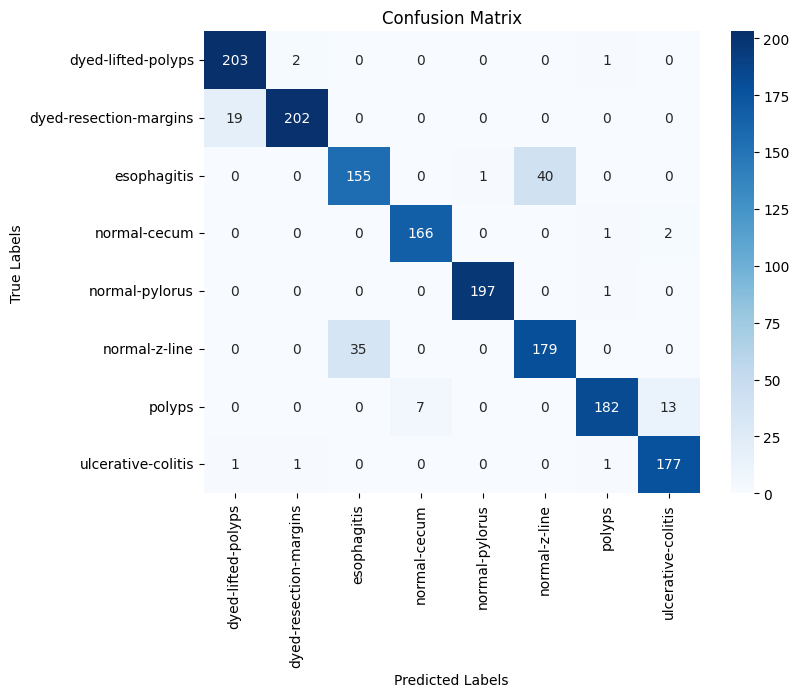

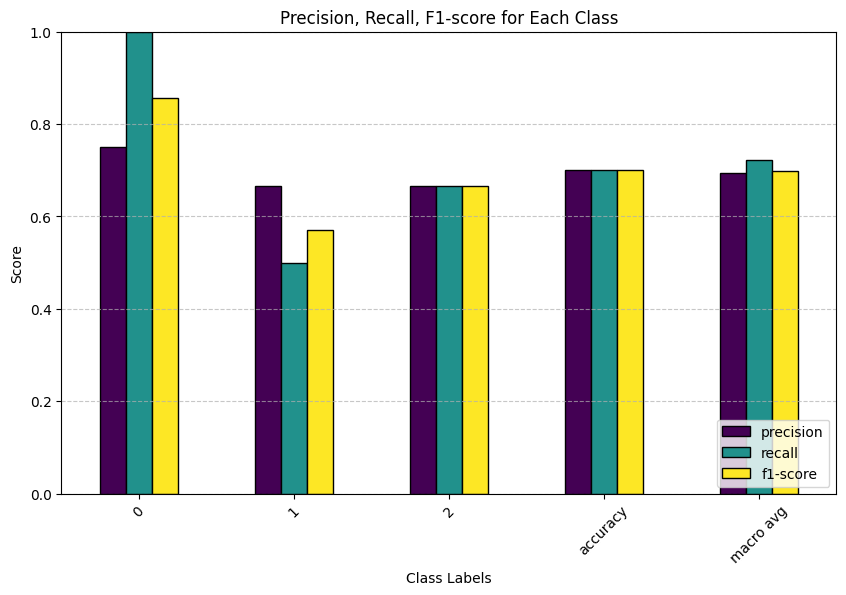

Matthews Correlation Coefficient (MCC): 0.5606


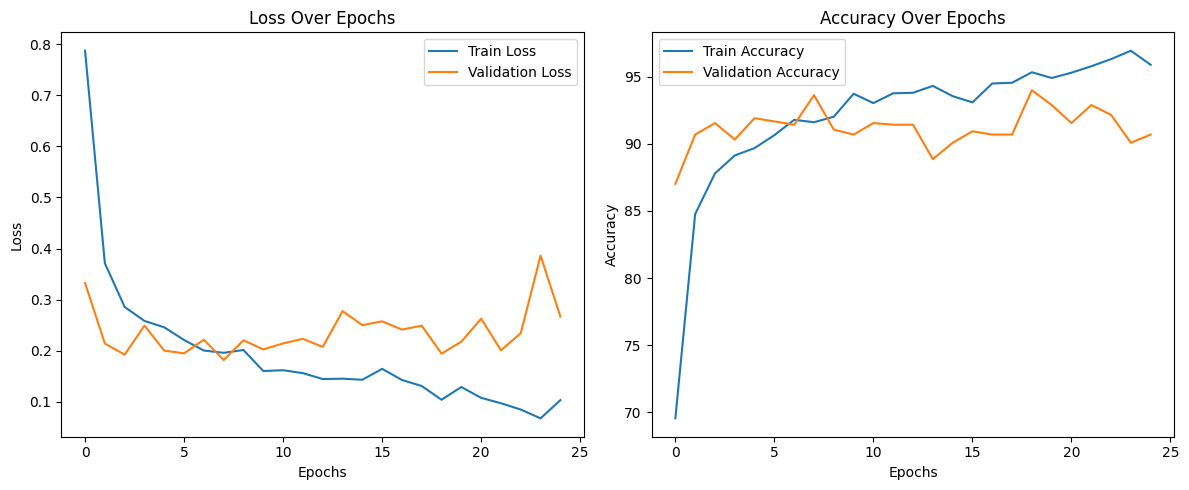

In [ ]:
from sklearn.metrics import matthews_corrcoef, confusion_matrix, classification_report
from sklearn.metrics import classification_report, matthews_corrcoef
import pandas as pd
import matplotlib.pyplot as plt

def compute_mcc(model, dataloader, device, class_names):
    """
    Computes the Matthews Correlation Coefficient (MCC) for the given model and dataloader.
    Also returns the confusion matrix and classification report.
    """
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute MCC
    mcc = matthews_corrcoef(all_labels, all_preds)

    # Compute Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Compute Classification Report
    report = classification_report(all_labels, all_preds, target_names=class_names)

    return mcc, cm, report
class_names = dataset.classes  # Extract class names from the original dataset
# Load the best model
model.load_state_dict(torch.load("best_efficientnet_vit_model.pth"))

# Compute MCC and additional metrics on the test set
test_mcc, confusion_mat, classification_rep = compute_mcc(model, test_loader, DEVICE, class_names)

# Display Results
print(f"Matthews Correlation Coefficient (MCC): {test_mcc:.4f}")
print("\nConfusion Matrix:")
print(confusion_mat)
print("\nClassification Report:")
print(classification_rep)





# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()



# Assuming you have y_true and y_pred (true labels and predictions)


# Define y_true and y_pred (Example values, replace with actual data)
y_true = [0, 1, 1, 0, 2, 2, 1, 0, 2, 1]  # True class labels
y_pred = [0, 1, 0, 0, 2, 1, 1, 0, 2, 2]  # Model's predictions

# Generate classification report
report = classification_report(y_true, y_pred, output_dict=True)
df_report = pd.DataFrame(report).transpose()  # Convert to DataFrame

# Plot Precision, Recall, and F1-score
df_report[['precision', 'recall', 'f1-score']].iloc[:-1].plot(
    kind='bar', figsize=(10, 6), colormap='viridis', edgecolor='black'
)
plt.title("Precision, Recall, F1-score for Each Class")
plt.xlabel("Class Labels")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.ylim(0, 1)  # Values between 0 and 1
plt.legend(loc="lower right")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Compute MCC
test_mcc = matthews_corrcoef(y_true, y_pred)

# Print MCC
print(f"Matthews Correlation Coefficient (MCC): {test_mcc:.4f}")



plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
from PIL import Image

def preprocess_image(image_path, img_size=224):
    transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    image = Image.open(image_path).convert("RGB")  # Đảm bảo ảnh có 3 kênh (RGB)
    return transform(image).unsqueeze(0)  # Thêm batch dimension (1, 3, H, W)


def predict_image(image_path, model, class_names, device):
    model.eval()  # Ensure the model is in evaluation mode
    image_tensor = preprocess_image(image_path).to(device)

    with torch.no_grad():  # Disable gradient computation
        outputs = model(image_tensor)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        pred_idx = torch.argmax(probs, dim=1).item()
        pred_class = class_names[pred_idx]
        pred_prob = probs[0][pred_idx].item()

    return pred_class, pred_prob


 normal-cecum ( 1.00)


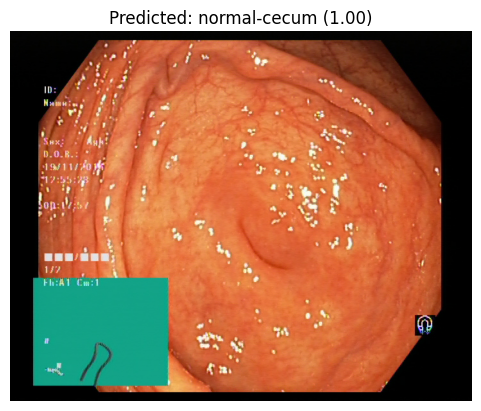

In [ ]:
image_path = "/content/0d452625-bd76-4a9e-9c75-42f9604a173c.jpg"  # Đường dẫn tới ảnh cần kiểm tra
predicted_class, confidence = predict_image(image_path, model, class_names, DEVICE)
print(f" {predicted_class} ( {confidence:.2f})")

import matplotlib.pyplot as plt

image = Image.open(image_path)
plt.imshow(image)
plt.title(f"Predicted: {predicted_class} ({confidence:.2f})")
plt.axis("off")
plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')